In [1]:
import os
from matplotlib import pyplot as plt
import random
import torch
import numpy as np
import json

def set_seed(seed, env=None, eval_env=None):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    if env is not None:
        env.seed(seed)
    if eval_env is not None:
        eval_env.seed(seed)
        
def list_folders_name(path):
    return [o for o in os.listdir(path) if os.path.isdir(os.path.join(path,o))]

/home/jsu/anaconda3/envs/of4on_ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_of4on_result(baseline_result_root, of4on_result_root, of4onDB_result_root, game = "Pong", baseline_id = "baselineAdam", offline_epochs = 10):

    env_name = f"{game}NoFrameskip-v0"


    # load baseline results
    baseline_result_dirs = [ os.path.join(baseline_result_root, o) for o in list_folders_name(baseline_result_root) if (env_name in o) and (baseline_id in o)]
    baseline_result_filename = "evaluation.csv"
    baseline_results = []
    for dir in baseline_result_dirs:
        baseline_result = np.loadtxt(os.path.join(dir, baseline_result_filename), delimiter=',')
        baseline_results.append(baseline_result[:, 2])
    baseline_results = np.array(baseline_results)

    # load of4on results
    num_phases = 5
    offline_id = "offlineDiscreteCQL"
    offline_result_filename = "environment.csv"
    online_id = "onlineDoubleDQN"
    online_result_filename = "evaluation.csv"
    offline_epochs = offline_epochs
    offline_epochs_tag = f"{offline_epochs}epochs"
    
    ## offline boostrap online
    of4on_result_dirs = [ os.path.join(of4on_result_root, o) for o in list_folders_name(of4on_result_root) if env_name in o]
    of4on_result = {}
    for phase in range(1, 1+num_phases):
        of4on_result[phase] = {}
        # offline if exist
        of_phase_result_dirs = [dir for dir in of4on_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and offline_id in dir]
        of_phase_results = [np.loadtxt(os.path.join(dir, offline_result_filename), delimiter=',')[:, -1].max() for dir in of_phase_result_dirs]
        # online
        on_phase_result_dirs = [dir for dir in of4on_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and online_id in dir]
        on_phase_results = [np.loadtxt(os.path.join(dir, online_result_filename), delimiter=',')[:, -1] for dir in on_phase_result_dirs]
        on_steps = np.loadtxt(os.path.join(on_phase_result_dirs[0], online_result_filename), delimiter=',')[:, 1]
        
        of4on_result[phase]["offline"] = of_phase_results
        of4on_result[phase]["online"] = on_phase_results
        of4on_result[phase]["on_steps"] = on_steps

    # double boostrap
    of4onDB_result_dirs = [ os.path.join(of4onDB_result_root, o) for o in list_folders_name(of4onDB_result_root) if env_name in o]
    of4onDB_result = {}
    for phase in range(1, 1+num_phases):
        of4onDB_result[phase] = {}
        # offline if exist
        of_phase_result_dirs = [dir for dir in of4onDB_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and offline_id in dir]
        of_phase_results = [np.loadtxt(os.path.join(dir, offline_result_filename), delimiter=',')[:, -1].max() for dir in of_phase_result_dirs]
        # online
        on_phase_result_dirs = [dir for dir in of4onDB_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and online_id in dir]
        on_phase_results = [np.loadtxt(os.path.join(dir, online_result_filename), delimiter=',')[:, -1] for dir in on_phase_result_dirs]
        on_steps = np.loadtxt(os.path.join(on_phase_result_dirs[0], online_result_filename), delimiter=',')[:, 1]
        
        of4onDB_result[phase]["offline"] = of_phase_results
        of4onDB_result[phase]["online"] = on_phase_results
        of4onDB_result[phase]["on_steps"] = on_steps

    # plot
    fig, ax = plt.subplots(figsize=(10, 5))
    # baseline: online
    baseline_color = "black"
    steps = np.loadtxt(os.path.join(baseline_result_dirs[0], baseline_result_filename), delimiter=',')[:, 1]
    mean = baseline_results.mean(axis=0)
    std = baseline_results.std(axis=0)
    ax.plot(steps, mean, label="baseline: only online", color=baseline_color)
    ax.fill_between(steps, mean-std, mean+std, alpha=0.3, color=baseline_color)

    # of4on
    start_step = 0
    online_color = 'blue'
    offline_color = 'red'
    steps = []
    on_means = []
    on_stds = []
    for phase in range(1, 1+num_phases):
        of_phase_results = of4on_result[phase]["offline"]
        on_phase_results = np.stack(of4on_result[phase]["online"])
        on_steps = of4on_result[phase]["on_steps"] + start_step
        
        mean = on_phase_results.mean(axis=0)
        std = on_phase_results.std(axis=0)
        on_means += mean.tolist()
        on_stds += std.tolist()
        
        if len(of_phase_results) != 0:
            of_phase_results = np.array(of_phase_results)
            mean = of_phase_results.mean()
            std = of_phase_results.std()
            ax.errorbar(on_steps[-1], mean, yerr=std, xerr=0, marker='s', mfc=offline_color, mec=offline_color, color=offline_color, label=f"of4on: offline_{offline_epochs}EP" if phase==4 else None)

        # update start_step
        start_step = on_steps[-1]
        
        steps += on_steps.tolist()

    on_means = np.array(on_means)
    on_stds = np.array(on_stds)
    ax.plot(steps, on_means, label="of4on: online", color=online_color)
    ax.fill_between(steps, on_means-on_stds, on_means+on_stds, alpha=0.3, color=online_color)

    # of4on: double boostrap
    start_step = 0
    online_color = 'green'
    offline_color = 'purple'
    steps = []
    on_means = []
    on_stds = []
    for phase in range(1, 1+num_phases):
        of_phase_results = of4onDB_result[phase]["offline"]
        on_phase_results = np.stack(of4onDB_result[phase]["online"])
        on_steps = of4onDB_result[phase]["on_steps"] + start_step
        
        mean = on_phase_results.mean(axis=0)
        std = on_phase_results.std(axis=0)
        on_means += mean.tolist()
        on_stds += std.tolist()
        
        if len(of_phase_results) != 0:
            of_phase_results = np.array(of_phase_results)
            mean = of_phase_results.mean()
            std = of_phase_results.std()
            ax.errorbar(on_steps[-1], mean, yerr=std, xerr=0, marker='s', mfc=offline_color, mec=offline_color, color=offline_color, label=f"of4on: offline_{offline_epochs}EP_DB" if phase==4 else None)

        # update start_step
        start_step = on_steps[-1]
        
        steps += on_steps.tolist()

    on_means = np.array(on_means)
    on_stds = np.array(on_stds)
    ax.plot(steps, on_means, label="of4on: online_DB", color=online_color)
    ax.fill_between(steps, on_means-on_stds, on_means+on_stds, alpha=0.3, color=online_color)

    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Reward")
    ax.set_title(game)
    ax.legend()
    
    fig.savefig(f"{game}_of4on_{offline_epochs}EP.png")

In [3]:
def get_mean_and_std(arr):
    return arr.mean(axis=0), arr.std(axis=0)

def plot_baseline(ax, game, rewards, steps, linecolor, label):
    means, stds = get_mean_and_std(rewards)
    ax.plot(steps, means, label=label, color=linecolor)
    ax.fill_between(steps, means-stds, means+stds, alpha=0.3, color=linecolor)

    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Reward")
    ax.set_title(game)
    ax.legend()

def plot_of4on(
    ax, game,
    rewards_on, steps_on, color_on, label_on,
    rewards_of, steps_of, color_of, label_of):
    """_summary_

    Args:
        ax (_type_): _description_
        rewards_on (numpy array): (num_seeds, epochs_online)
        steps_on (numpy_array): (epochs_online)
        color_on (str): 
        label_on (str): 
        rewards_of (numpy array): (num_phases,)
        steps_of (numpy_array): (num_phases,)
        color_of (str): 
        label_of (str): 
    """
    # online
    means_on, stds_on = get_mean_and_std(rewards_on)
    ax.plot(steps_on, means_on, label=label_on, color=color_on)
    ax.fill_between(steps_on, means_on-stds_on, means_on+stds_on, alpha=0.3, color=color_on)
    
    # offline
    means_of, stds_of = get_mean_and_std(rewards_of)
    ax.errorbar(steps_of, means_of, yerr=stds_of, xerr=0, marker='s', mfc=color_of, mec=color_of, color=color_of, label=label_of)

    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Reward")
    ax.set_title(game)
    ax.legend()

# Load results
# Assume there is only one experiment result in the target directory.
# For example, "230821-190006" in "log/PongNoFrameskip-v4/cql-qrdqn-bt1-of5grad/100/230821-190006/
def load_result(log_root, game_envname, seed, algo, result_filename, folder_time_tag = None):
    result_path = os.path.join(log_root, game_envname, algo, str(seed))
    experiment_result_foldernames = list_folders_name(result_path)
    if folder_time_tag is not None:
        experiment_result_foldernames = [folder for folder in experiment_result_foldernames if folder_time_tag in folder]
    assert len(experiment_result_foldernames) == 1
    result_path = os.path.join(result_path, experiment_result_foldernames[0], result_filename)

    with open(result_path, 'r') as f:
        result = json.load(f)
    return result

In [9]:
def plot_of4on_per_phase(ax, game, rewards_on, steps_on, color_on, label_on, rewards_of, steps_of, color_of, label_of):
    """_summary_
    Args:
        ax (_type_): _description_
        rewards_on (numpy array): (num_seeds, epochs_online)
        steps_on (numpy_array): (epochs_online)
        color_on (str): 
        label_on (str): 
        rewards_of (numpy array): (num_seeds, num_phases,)
        steps_of (numpy_array): (num_phases,)
        color_of (str): 
        label_of (str): 
    """
    num_seeds, num_phases = rewards_of.shape[0], rewards_of.shape[1]
    phase_step_indices = [np.where(steps_on==step_of)[0][0] for step_of in steps_of]
    #print(f"[{num_phases} phases]:\n\t{steps_of}\n\t{phase_step_indices}")

    phase_step_on_start_idx = 0
    label_on_shown = None
    label_of_shown = None
    for phase in range(num_phases):
        if phase == num_phases-1:
            label_on_shown = label_on
            label_of_shown = label_of
        phase_step_of = steps_of[phase]
        phase_rewards_of = rewards_of[:, phase]
        phase_step_on_end_idx = phase_step_indices[phase]
        #print(f"phase:{phase}: phase_step_on_start_idx:{phase_step_on_start_idx}, phase_step_on_end_idx:{phase_step_on_end_idx}")
        if phase == 0: # first phase to start, so there is no previous offline learning
            phase_rewards_on = rewards_on[:, phase_step_on_start_idx:(phase_step_on_end_idx+1)]
            phase_steps_on = steps_on[phase_step_on_start_idx:(phase_step_on_end_idx+1)]
        else: # starting from the 2nd phase, an offline learning is conducted in the previous phase
            phase_rewards_on = np.zeros((num_seeds, 1+(phase_step_on_end_idx-phase_step_on_start_idx+1)))
            phase_steps_on = np.zeros((1+(phase_step_on_end_idx-phase_step_on_start_idx+1)))
            phase_rewards_on[:, 0] = rewards_of[:, phase-1]
            phase_rewards_on[:, 1:] = rewards_on[:, phase_step_on_start_idx:(phase_step_on_end_idx+1)]
            phase_steps_on[0] = steps_of[phase-1]
            phase_steps_on[1:] = steps_on[phase_step_on_start_idx:(phase_step_on_end_idx+1)]
        
        # plot online part starting from the performance point of previous offline learning if it exists
        phase_means_on, phase_stds_on = get_mean_and_std(phase_rewards_on)
        ax.plot(phase_steps_on, phase_means_on, label=label_on_shown, color=color_on)
        ax.fill_between(phase_steps_on, phase_means_on-phase_stds_on, phase_means_on+phase_stds_on, alpha=0.3, color=color_on)

        # plot offline part starting from the last performance point of the current online learning
        # since they two correspond to the same global environment steps, increase the step of offline-learning
        # by 1 to avoid overlapping
        phase_rewards_on2of = np.zeros((num_seeds, 2))
        phase_rewards_on2of[:, 0] = phase_rewards_on[:, -1]
        phase_rewards_on2of[:, 1] = phase_rewards_of
        phase_steps_on2of = np.zeros((2), dtype=int)
        phase_steps_on2of[0] = phase_steps_on[-1]
        phase_steps_on2of[1] = phase_step_of
        phase_means_on2of, phase_stds_on2of = get_mean_and_std(phase_rewards_on2of)
        ax.plot(phase_steps_on2of, phase_means_on2of, color=color_of, linestyle='dashed') # marker='s', label=label_of_shown
        #ax.fill_between(phase_steps_on2of, phase_means_on2of-phase_stds_on2of, phase_means_on2of+phase_stds_on2of, alpha=0.3, color=color_of, linestyle='dashed')
        
        phase_step_on_start_idx = phase_step_on_end_idx+1

    ax.scatter(steps_of, rewards_of.mean(axis=0), c=color_of, marker='s', s=50, label=label_of_shown, alpha=0.7, edgecolors='none')
    
    ax.set_xlabel("Steps")
    ax.set_ylabel("Average Reward")
    ax.set_title(game)
    ax.legend(loc='upper left')
    
def load_experiment_result(
    log_root, game, seeds, phases,
    epochs_online, baseline_algo, of4on_algo,
    online_policy_perf_filename, best_offline_policy_perf_filename,
    epochs_online_bs = None,
    folder_time_tag = None,
    ):
    game_envname = f"{game}NoFrameskip-v4"
    ## baseline algo
    if epochs_online_bs is None:
        epochs_online_bs = epochs_online
    rewards_bs = np.zeros((len(seeds), epochs_online_bs+1))
    steps_bs = None
    for idx, seed in enumerate(seeds):
        result_bs = load_result(log_root, game_envname, seed, baseline_algo, online_policy_perf_filename, folder_time_tag="2309")
        if steps_bs is None:
            steps_bs = np.array([int(key) for key in result_bs.keys()])

        rewards_bs[idx, :] = np.array(list(result_bs.values()))
    # temporary workaround: baseline runs for 50 epochs while of4on runs for 6 epochs
    rewards_bs = rewards_bs[:, :(epochs_online+1)]
    steps_bs = steps_bs[:(epochs_online+1)]

    ## of4on algo
    rewards_on = np.zeros((len(seeds), epochs_online+1))
    steps_on = None
    rewards_of = np.zeros((len(seeds), phases))
    steps_of = None
    for idx, seed in enumerate(seeds):
        result_on = load_result(log_root, game_envname, seed, of4on_algo, online_policy_perf_filename, folder_time_tag)
        if steps_on is None:
            steps_on = np.array([int(key) for key in result_on.keys()])
        rewards_on[idx, :] = np.array(list(result_on.values()))

        result_of = load_result(log_root, game_envname, seed, of4on_algo, best_offline_policy_perf_filename, folder_time_tag)
        if steps_of is None:
            steps_of = np.array([int(key) for key in result_of.keys()])
        rewards_of[idx, :] = np.array(list(result_of.values()))
        
    return rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of

def plot_of4on_with_baseline(
    game, baseline_algo, of4on_algo,
    rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of,
    of4on_type = None,
):
    fig, ax = plt.subplots(figsize=(10, 5))
    color_bs = 'black'
    label_bs = f'baseline-{baseline_algo}'
    plot_baseline(ax, game, rewards_bs, steps_bs, color_bs, label_bs)

    color_on = "blue"
    label_on = f"of4on-online"
    color_of = "red"
    label_of = f"of4on-offline"
    plot_of4on_per_phase(
        ax, game,
        rewards_on, steps_on, color_on, label_on,
        rewards_of, steps_of, color_of, label_of)
    if of4on_type is not None:
        ax.set_title(f"{game}: {of4on_type}")
    fig.savefig(f'{game}-{of4on_algo}.png', dpi=300)

game: Pong, time_tag: 230904, of4on_type: DirectCopy_BufferNoReset
game: Breakout, time_tag: 230904, of4on_type: DirectCopy_BufferNoReset
game: NameThisGame, time_tag: 230903-01, of4on_type: DirectCopy_BufferNoReset
game: Qbert, time_tag: 230904, of4on_type: DirectCopy_BufferNoReset
game: Gravitar, time_tag: 230904, of4on_type: DirectCopy_BufferNoReset


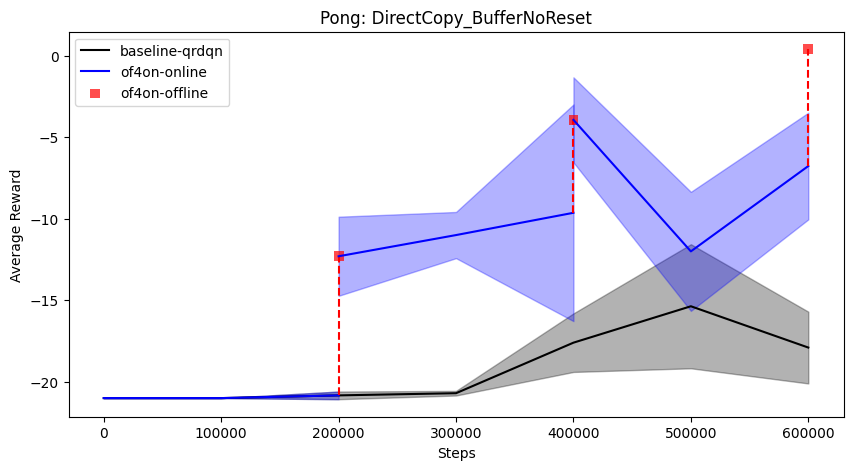

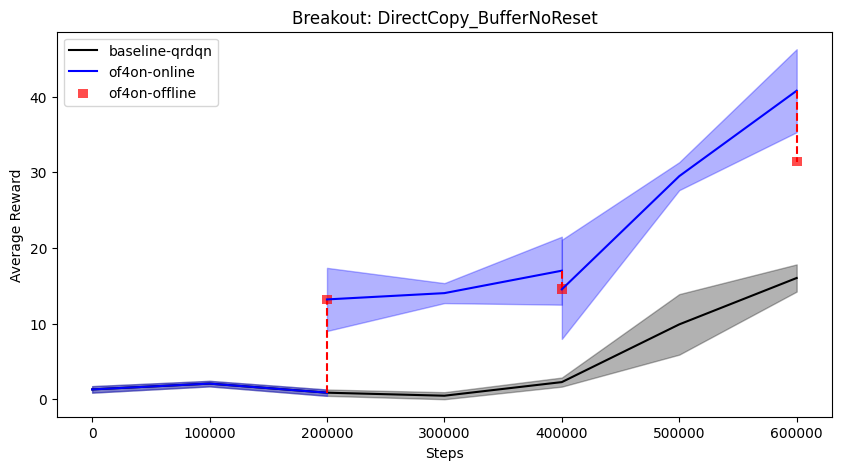

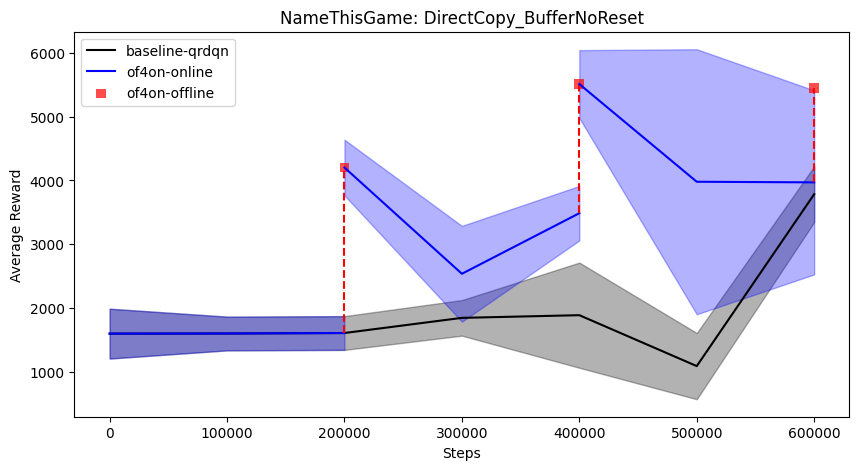

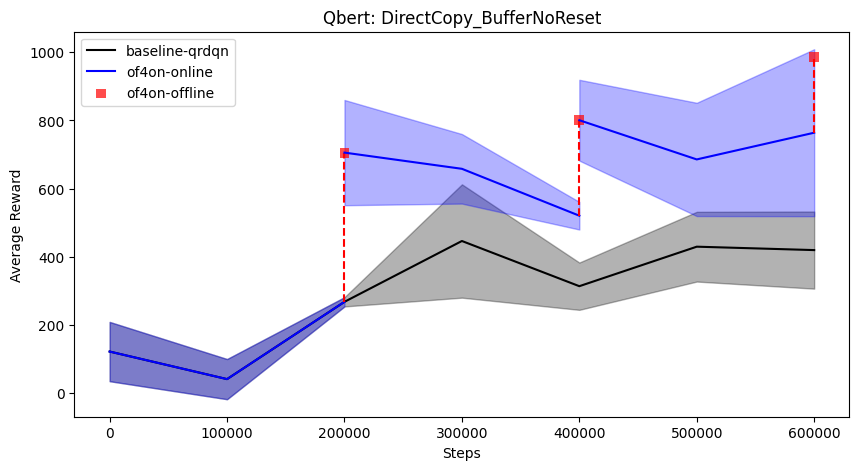

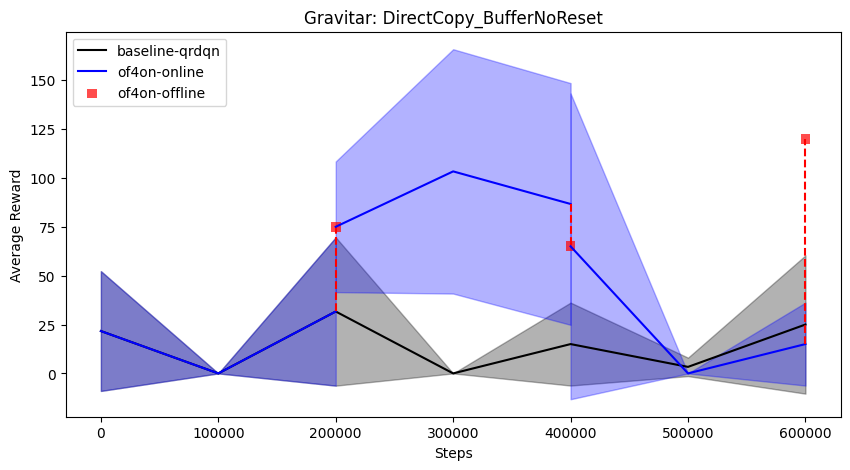

In [10]:
#230903-01, 230903-04, 230903-05
log_root = "/home/jsu/Desktop/Projects/Offline4Online/tianshou/result_vis/log"
online_policy_perf_filename = "online_policy_test_rewards.json"
best_offline_policy_perf_filename = "best_offline_policies_performance.json"
seeds = [100, 200, 300]
baseline_algo = "qrdqn" # online RL
of4on_kind = "bt1-of5grad"
of4on_algo = f"cql-{baseline_algo}-{of4on_kind}"
epochs_online = 6
phases = 3

games = ['Pong', 'Breakout', 'NameThisGame', 'Qbert', 'Gravitar']
folder_time_tags = ['230904', '230904', '230903-01', '230904', '230904']
of4on_type = "DirectCopy_BufferNoReset"
for time_tag, game in zip(folder_time_tags, games):
    print(f"game: {game}, time_tag: {time_tag}, of4on_type: {of4on_type}")
    game_envname = f"{game}NoFrameskip-v4"
    rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of = load_experiment_result(
        log_root, game, seeds, phases,
        epochs_online, baseline_algo, of4on_algo,
        online_policy_perf_filename, best_offline_policy_perf_filename,
        epochs_online_bs = None,
        folder_time_tag = time_tag,
        )
    plot_of4on_with_baseline(
        game, baseline_algo, of4on_algo,
        rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of,
        of4on_type = of4on_type,
    )

time_tag: 230903-01, of4on_type: DirectCopy_BufferNoReset
time_tag: 230903-04, of4on_type: DirectCopy_BufferReset_RandomExplPerPhase
time_tag: 230903-05, of4on_type: DirectCopy_BufferReset_OnlineExplPerPhase


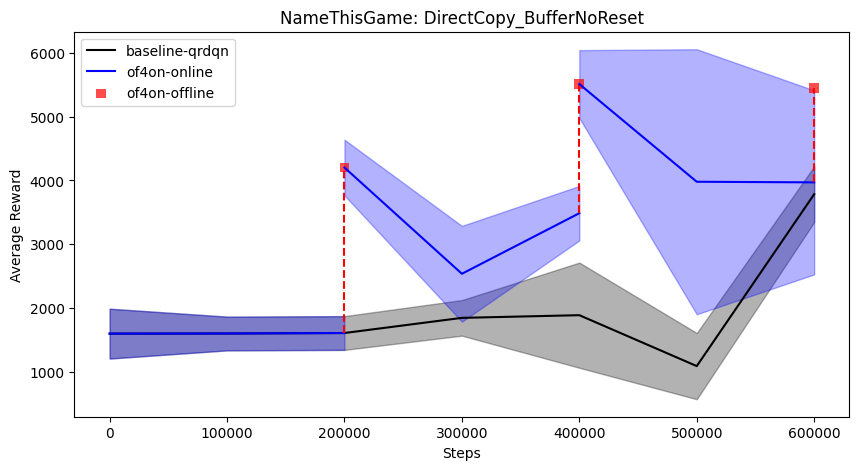

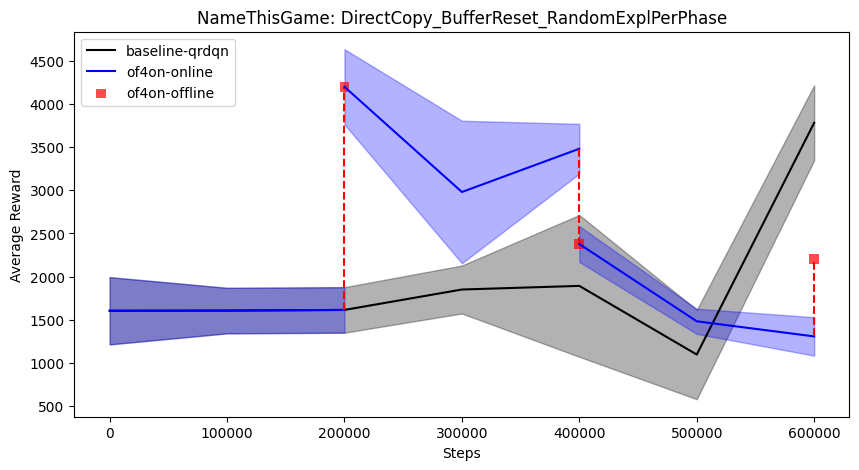

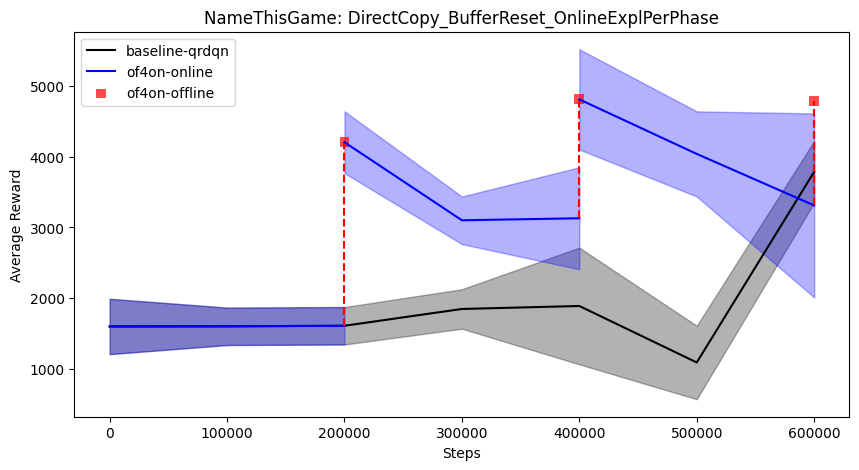

In [15]:
#230903-01, 230903-04, 230903-05
log_root = "/home/jsu/Desktop/Projects/Offline4Online/tianshou/result_vis/log"
online_policy_perf_filename = "online_policy_test_rewards.json"
best_offline_policy_perf_filename = "best_offline_policies_performance.json"
game = "NameThisGame"
game_envname = f"{game}NoFrameskip-v4"
seeds = [100, 200, 300]
baseline_algo = "qrdqn" # online RL
of4on_kind = "bt1-of5grad"
of4on_algo = f"cql-{baseline_algo}-{of4on_kind}"
epochs_online = 6
phases = 3

folder_time_tags = ['230903-01', '230903-04', '230903-05']
of4on_types = [
    "DirectCopy_BufferNoReset",
    "DirectCopy_BufferReset_RandomExplPerPhase",
    "DirectCopy_BufferReset_OnlineExplPerPhase"]
for time_tag, of4on_type in zip(folder_time_tags, of4on_types):
    print(f"time_tag: {time_tag}, of4on_type: {of4on_type}")
    rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of = load_experiment_result(
        log_root, game, seeds, phases,
        epochs_online, baseline_algo, of4on_algo,
        online_policy_perf_filename, best_offline_policy_perf_filename,
        epochs_online_bs = None,
        folder_time_tag = time_tag,
        )
    plot_of4on_with_baseline(
        game, baseline_algo, of4on_algo,
        rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of,
        of4on_type = of4on_type,
    )

In [5]:
log_root = "/home/suj/Desktop/projects/of4on/tianshou/result_vis/log"
online_policy_perf_filename = "online_policy_test_rewards.json"
best_offline_policy_perf_filename = "best_offline_policies_performance.json"
game = "Pong"
game_envname = f"{game}NoFrameskip-v4"
seeds = [100, 200, 300]
baseline_algo = "qrdqn" # online RL
of4on_kind = "bt1-of5grad"
of4on_algo = f"cql-{baseline_algo}-{of4on_kind}"
epochs_online = 6
phases = 3

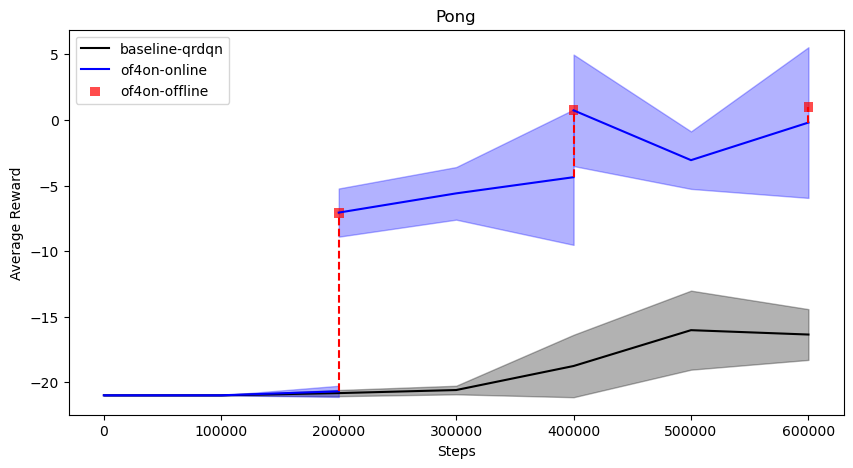

In [6]:
rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of = load_experiment_result(
    log_root, game, seeds, phases,
    epochs_online, baseline_algo, of4on_algo,
    online_policy_perf_filename, best_offline_policy_perf_filename
    )
plot_of4on_with_baseline(
    game, baseline_algo, of4on_algo,
    rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of,
)

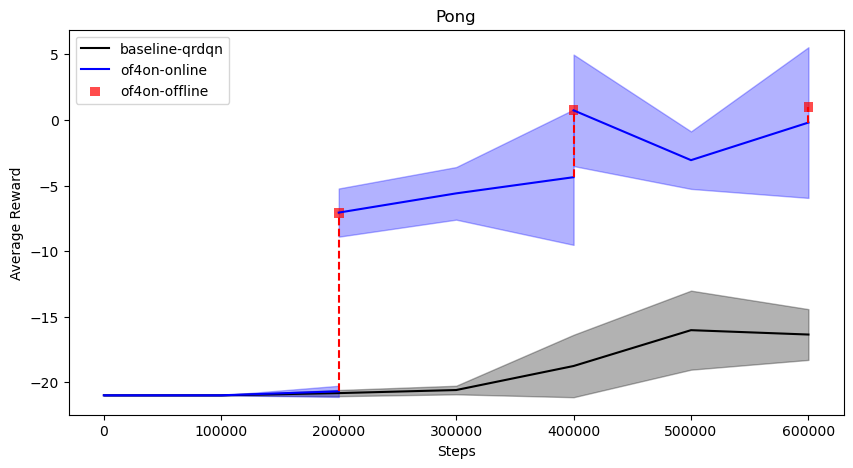

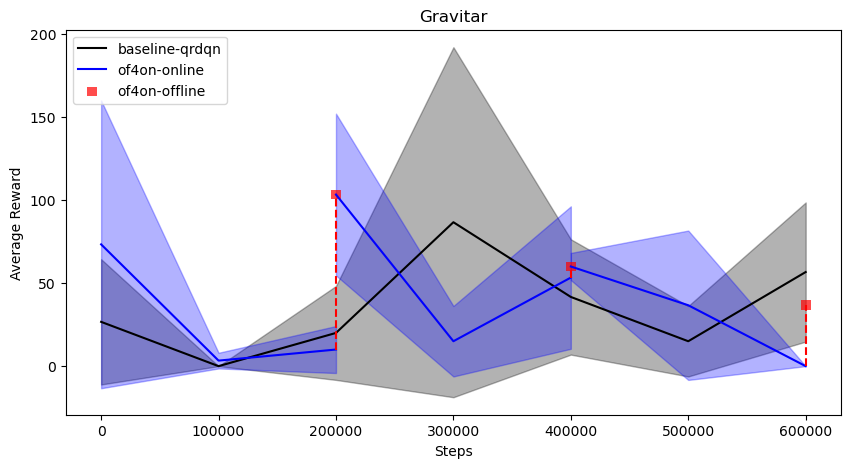

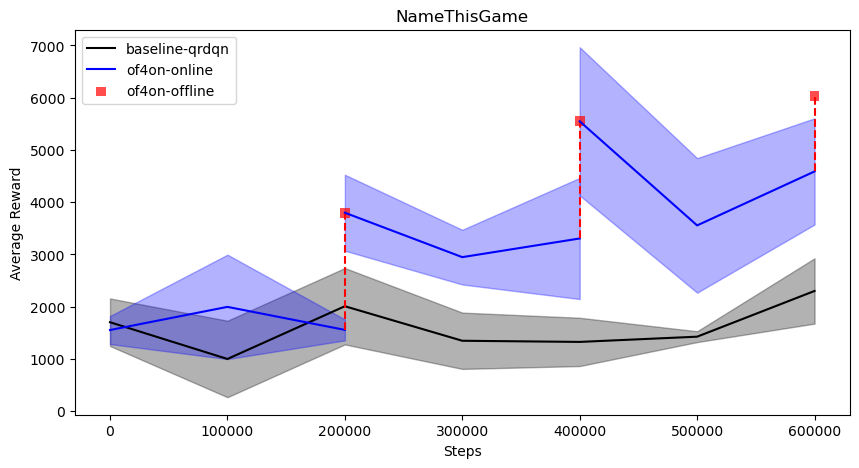

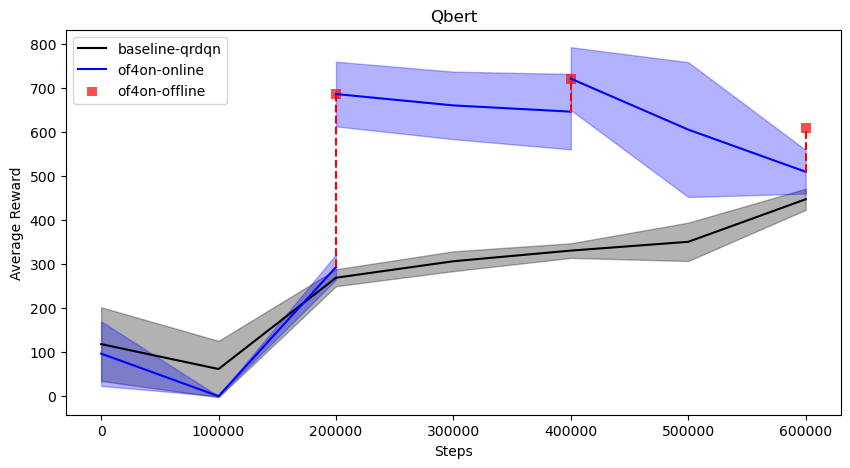

In [9]:
# PongNoFrameskip-v4 BreakoutNoFrameskip-v4  GravitarNoFrameskip-v4  NameThisGameNoFrameskip-v4  QbertNoFrameskip-v4
log_root = "/home/suj/Desktop/projects/of4on/tianshou/result_vis/log"
online_policy_perf_filename = "online_policy_test_rewards.json"
best_offline_policy_perf_filename = "best_offline_policies_performance.json"

seeds = [100, 200, 300]
baseline_algo = "qrdqn" # online RL
of4on_kind = "bt1-of5grad"
of4on_algo = f"cql-{baseline_algo}-{of4on_kind}"
epochs_online = 6
phases = 3

games = ["Pong", "Gravitar", "NameThisGame", "Qbert"] #Breakout
for game in games:
    rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of = load_experiment_result(
        log_root, game, seeds, phases,
        epochs_online, baseline_algo, of4on_algo,
        online_policy_perf_filename, best_offline_policy_perf_filename,
        epochs_online_bs = None
        )
    plot_of4on_with_baseline(
        game, baseline_algo, of4on_algo,
        rewards_bs, steps_bs, rewards_on, steps_on, rewards_of, steps_of,
    )

In [12]:
## baseline algo
rewards_bs = np.zeros((len(seeds), epochs_online+1))
steps_bs = None
for idx, seed in enumerate(seeds):
    result_bs = load_result(log_root, game_envname, seed, baseline_algo, online_policy_perf_filename)
    if steps_bs is None:
        steps_bs = np.array([int(key) for key in result_bs.keys()])

    rewards_bs[idx, :] = np.array(list(result_bs.values()))

## of4on algo
rewards_on = np.zeros((len(seeds), epochs_online+1))
steps_on = None
rewards_of = np.zeros((len(seeds), phases))
steps_of = None
for idx, seed in enumerate(seeds):
    result_on = load_result(log_root, game_envname, seed, of4on_algo, online_policy_perf_filename)
    if steps_on is None:
        steps_on = np.array([int(key) for key in result_on.keys()])
    rewards_on[idx, :] = np.array(list(result_on.values()))

    result_of = load_result(log_root, game_envname, seed, of4on_algo, best_offline_policy_perf_filename)
    if steps_of is None:
        steps_of = np.array([int(key) for key in result_of.keys()])
    rewards_of[idx, :] = np.array(list(result_of.values()))

Baseline:      [-21.     -21.     -20.8667 -18.1333 -18.6667 -13.2333 -15.9   ]
OF4ON:         [-21.     -20.9    -20.8667 -10.6333  -8.0667   2.3     -1.3   ]
OF4ON-offline: [-5.5333  0.3333  5.1333]


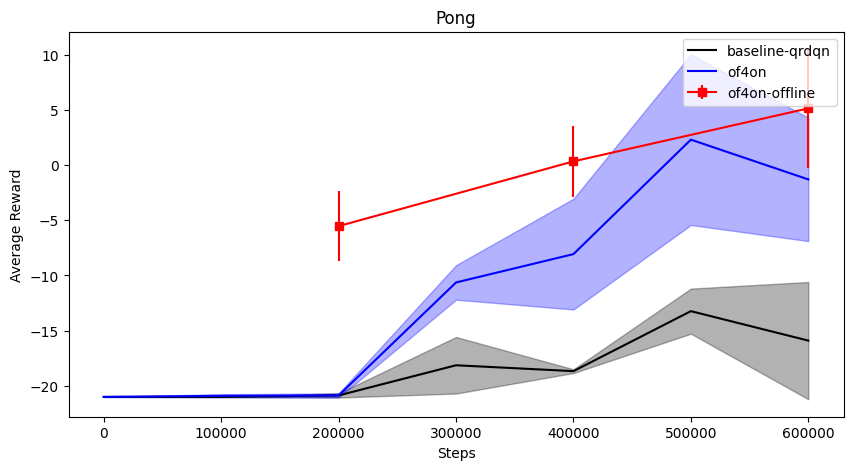

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
color_bs = 'black'
label_bs = f'baseline-{baseline_algo}'
plot_baseline(ax, game, rewards_bs, steps_bs, color_bs, label_bs)

color_on = "blue"
label_on = f"of4on"
color_of = "red"
label_of = f"of4on-offline"
plot_of4on(
    ax, game,
    rewards_on, steps_on, color_on, label_on,
    rewards_of, steps_of, color_of, label_of)

fig.savefig(f'{game}-{of4on_algo}.png', dpi=300)

rewards_bs_mean, _ = get_mean_and_std(rewards_bs)
rewards_on_mean, _ = get_mean_and_std(rewards_on)
reward_of_mean, _ = get_mean_and_std(rewards_of)
print(f"Baseline-{baseline_algo}:      {np.round(rewards_bs_mean, 4)}")
print(f"OF4ON-online:         {np.round(rewards_on_mean, 4)}")
print(f"OF4ON-offline: {np.round(reward_of_mean, 4)}")

[3 phases]:
	[200000 400000 600000]
	[2, 4, 6]
phase:0: phase_step_on_start_idx:0, phase_step_on_end_idx:2
phase:1: phase_step_on_start_idx:3, phase_step_on_end_idx:4
phase:2: phase_step_on_start_idx:5, phase_step_on_end_idx:6


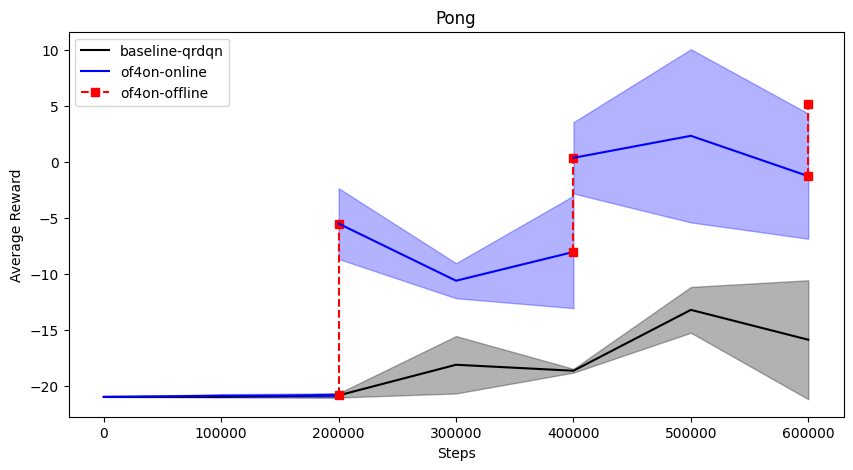

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
color_bs = 'black'
label_bs = f'baseline-{baseline_algo}'
plot_baseline(ax, game, rewards_bs, steps_bs, color_bs, label_bs)

color_on = "blue"
label_on = f"of4on-online"
color_of = "red"
label_of = f"of4on-offline"
plot_of4on_per_phase(
    ax, game,
    rewards_on, steps_on, color_on, label_on,
    rewards_of, steps_of, color_of, label_of)

#fig.savefig(f'{game}-{of4on_algo}.png', dpi=300)


In [54]:
steps_on

array([     0, 100000, 200000, 300000, 400000, 500000, 600000])

In [3]:
project_root="/home/jsu/Desktop/Projects/Offline4Online"
baseline_result_root=os.path.join(project_root, "result", "online") #"baseline" -> "online"
of4on_result_root=os.path.join(project_root, "result", "of4on")
of4onDB_result_root=os.path.join(project_root, "result", "of4on_db")

In [30]:
# Rainbow
eval_output_filename = "metrics.pth"
game = "asteroids"
env_name = game
seed_tag = "fixed_seed_in_torch" #"random_seed_in_torch"
baseline_result_dirs = [ os.path.join(baseline_result_root, o) for o in list_folders_name(baseline_result_root) if (env_name in o) and ("20230806" in o)]

baseline_result_dirs

['/home/jsu/Desktop/Projects/Offline4Online/result/online/asteroids_seed1000_baseline_onlineRainbow_20230806133046',
 '/home/jsu/Desktop/Projects/Offline4Online/result/online/asteroids_seed3000_baseline_onlineRainbow_20230806153638',
 '/home/jsu/Desktop/Projects/Offline4Online/result/online/asteroids_seed2000_baseline_onlineRainbow_20230806153638']

In [31]:
n_seeds = 3
steps = torch.load(os.path.join(baseline_result_dirs[0], eval_output_filename))['steps']
baseline_results = torch.zeros((n_seeds, len(steps)))
for idx, dir in enumerate(baseline_result_dirs):
    rewards = torch.tensor(torch.load(os.path.join(dir, eval_output_filename))['rewards'], dtype=float)
    steps = torch.load(os.path.join(dir, eval_output_filename))['steps']
    ave_returns = rewards.mean(dim=1)
    baseline_results[idx, :] = ave_returns

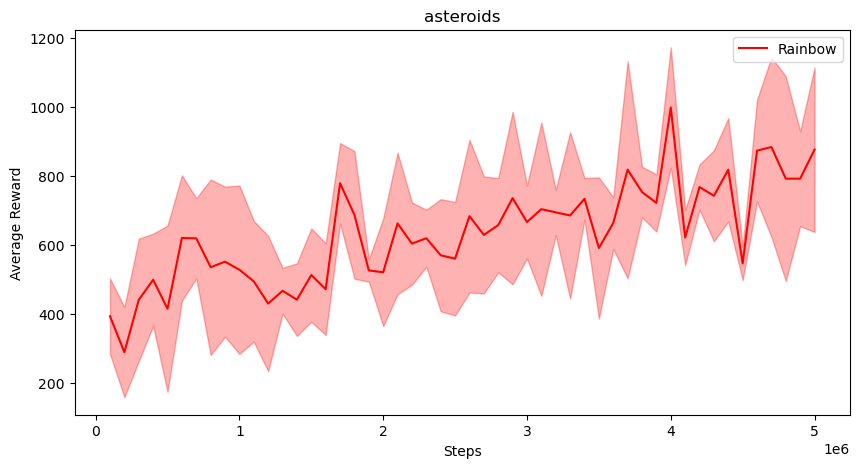

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
mean = baseline_results.mean(axis=0)
std = baseline_results.std(axis=0)
ax.plot(steps, mean, label="Rainbow", color='red')
ax.fill_between(steps, mean-std, mean+std, alpha=0.3, color='red')
ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title(game)
ax.legend()
fig.savefig(f"rainbow_{game}_{seed_tag}.png")

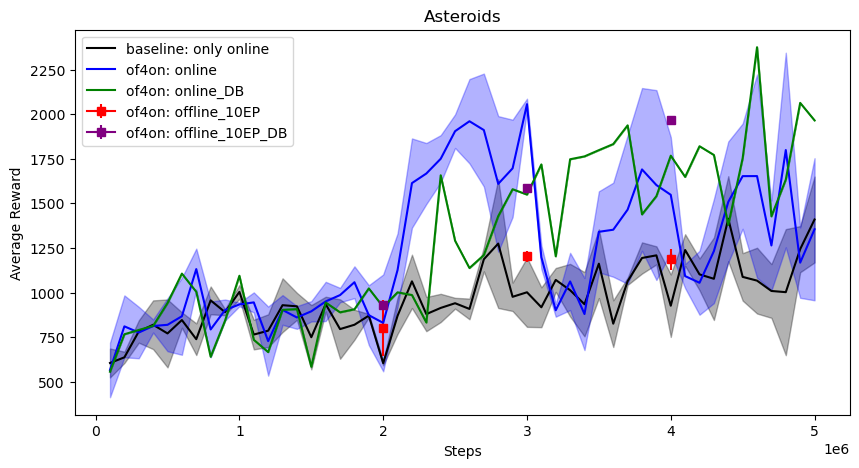

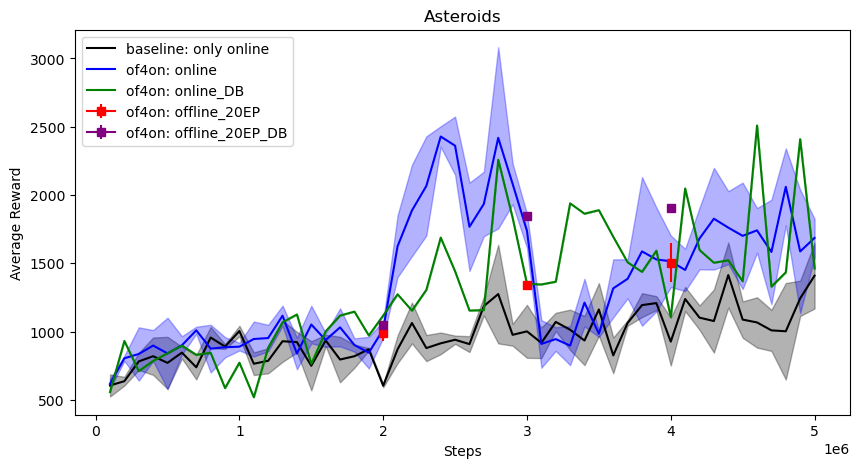

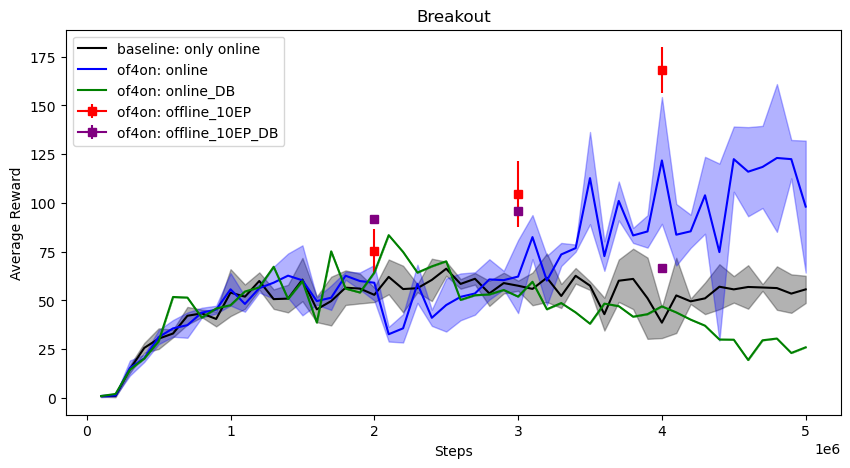

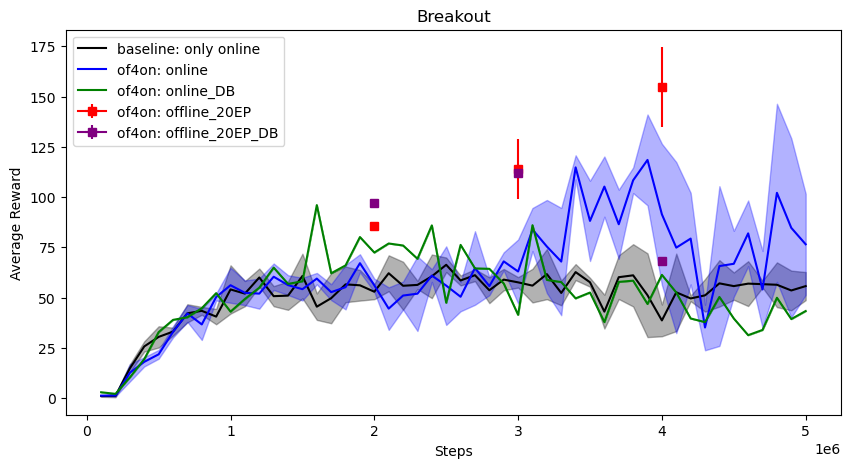

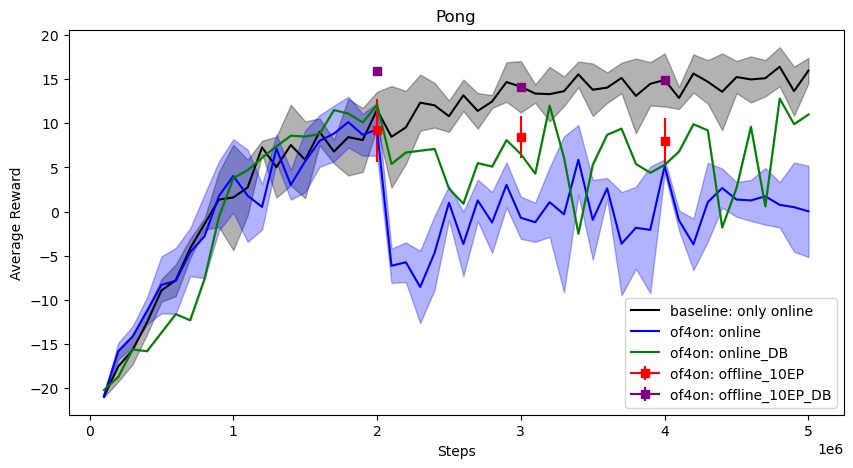

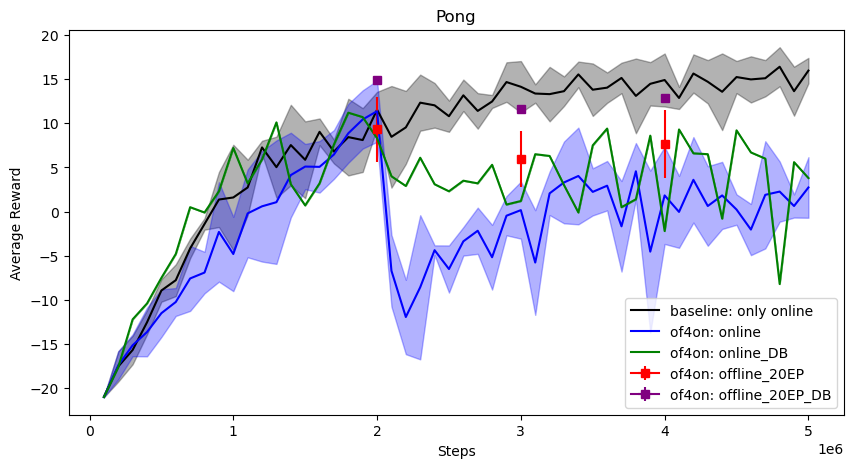

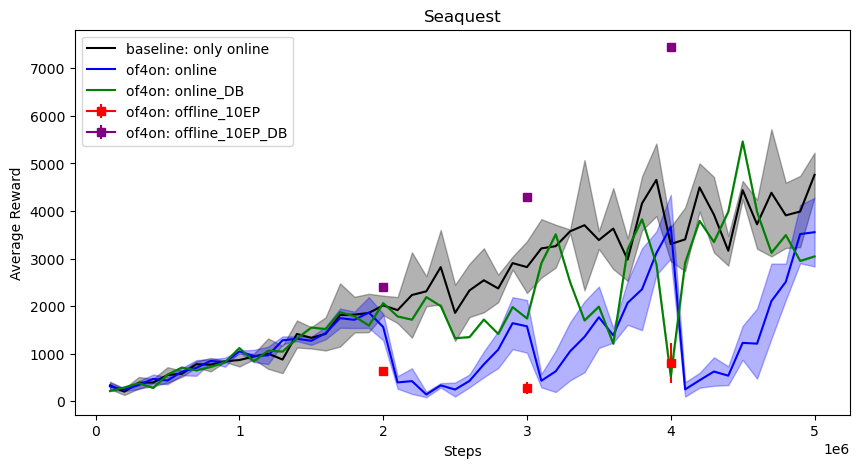

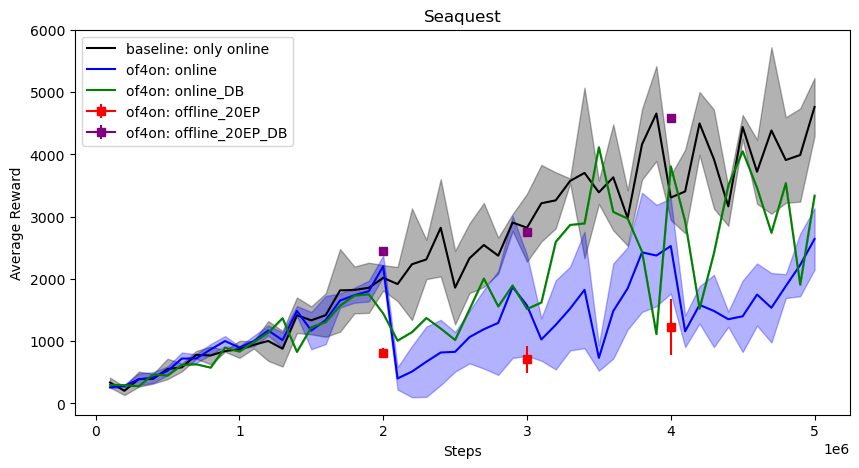

In [28]:
games = ['Asteroids', 'Breakout', 'Pong', 'Seaquest']
for game in games:
    plot_of4on_result(baseline_result_root, of4on_result_root, of4onDB_result_root, game = game, offline_epochs = 10)
    plot_of4on_result(baseline_result_root, of4on_result_root, of4onDB_result_root, game = game, offline_epochs = 20)

In [17]:
project_root="/home/jsu/Desktop/Projects/Offline4Online"
baseline_result_root=os.path.join(project_root, "result", "online") #"baseline" -> "online"
of4on_result_root=os.path.join(project_root, "result", "of4on")

game = "Pong"
env_name = f"{game}NoFrameskip-v0"
baseline_id = "baselineAdam"

baseline_result_dirs = [ os.path.join(baseline_result_root, o) for o in list_folders_name(baseline_result_root) if (env_name in o) and (baseline_id in o)]
of4on_result_dirs = [ os.path.join(of4on_result_root, o) for o in list_folders_name(of4on_result_root) if env_name in o]

In [18]:
of4onDB_result_dirs = [ os.path.join(of4onDB_result_root, o) for o in list_folders_name(of4onDB_result_root) if env_name in o]
print(env_name)
of4onDB_result_dirs

PongNoFrameskip-v0


['/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_offlineDiscreteCQL_phase2_10epochs_20230727062028',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_onlineDoubleDQN_phase1_10epochs_20230727021502',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_offlineDiscreteCQL_phase4_20epochs_20230728001713',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_onlineDoubleDQN_phase2_20epochs_20230727041310',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_offlineDiscreteCQL_phase3_10epochs_20230727115651',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_onlineDoubleDQN_phase2_10epochs_20230727041631',
 '/home/jsu/Desktop/Projects/Offline4Online/result/of4on_db/PongNoFrameskip-v0_seed2000_of4on_onlineDoubleDQN_phase3_20epochs_2023072

In [19]:
# arrange result in terms of phases
# the final perf of offline rl if exist
# online rl perf
num_phases = 5
offline_id = "offlineDiscreteCQL"
offline_result_filename = "environment.csv"
online_id = "onlineDoubleDQN"
online_result_filename = "evaluation.csv"
of4on_result = {}
of_phase_results = []
offline_epochs = 10
offline_epochs_tag = f"{offline_epochs}epochs"
for phase in range(1, 1+num_phases):
    of4on_result[phase] = {}
    # offline if exist
    of_phase_result_dirs = [dir for dir in of4onDB_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and offline_id in dir]
    of_phase_results = [np.loadtxt(os.path.join(dir, offline_result_filename), delimiter=',')[:, -1].max() for dir in of_phase_result_dirs]
    # online
    on_phase_result_dirs = [dir for dir in of4onDB_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and online_id in dir]
    on_phase_results = [np.loadtxt(os.path.join(dir, online_result_filename), delimiter=',')[:, -1] for dir in on_phase_result_dirs]
    on_steps = np.loadtxt(os.path.join(on_phase_result_dirs[0], online_result_filename), delimiter=',')[:, 1]
    
    of4on_result[phase]["offline"] = of_phase_results
    of4on_result[phase]["online"] = on_phase_results
    of4on_result[phase]["on_steps"] = on_steps

print(of4on_result)

{1: {'offline': [], 'online': [array([-20.2, -18.7, -15.6, -15.8, -13.7, -11.6, -12.3,  -7.6,  -0.6,
         3.8])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 2: {'offline': [15.96875], 'online': [array([ 4.7,  6.1,  7.4,  8.6,  8.5,  8.8, 11.5, 11.1, 10.1, 12.1])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 3: {'offline': [14.125], 'online': [array([5.4, 6.7, 6.9, 7.1, 2.6, 0.9, 5.5, 5.1, 8.1, 6.5])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 4: {'offline': [14.90625], 'online': [array([ 4.3, 12. ,  6.1, -2.5,  5.3,  8.7,  9.4,  5.4,  4.4,  5.3])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 5: {'offline': [], 'online': [array([ 6.8,  9.9,  9.2,

In [26]:
baseline_result_filename = "evaluation.csv"
baseline_results = []
for dir in baseline_result_dirs:
    baseline_result = np.loadtxt(os.path.join(dir, baseline_result_filename), delimiter=',')
    baseline_results.append(baseline_result[:, 2])
baseline_results = np.array(baseline_results)

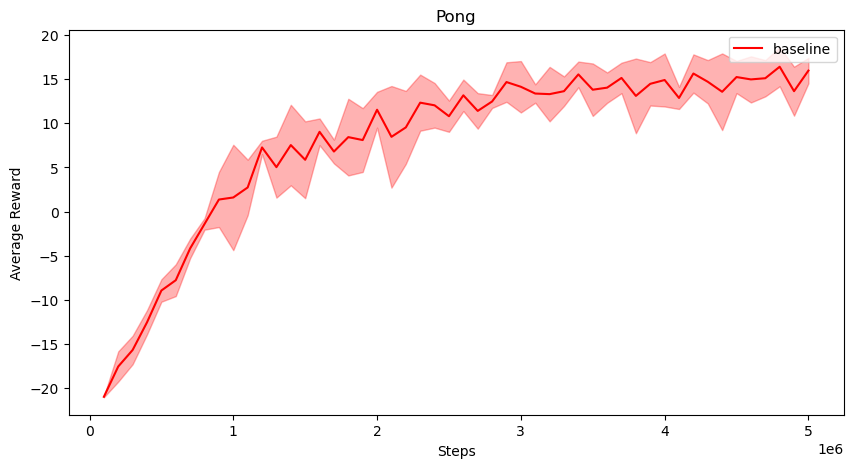

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
steps = np.loadtxt(os.path.join(baseline_result_dirs[0], baseline_result_filename), delimiter=',')[:, 1]
mean = baseline_results.mean(axis=0)
std = baseline_results.std(axis=0)
ax.plot(steps, mean, label="baseline", color='red')
ax.fill_between(steps, mean-std, mean+std, alpha=0.3, color='red')
ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title(game)
ax.legend()

In [37]:
# arrange result in terms of phases
# the final perf of offline rl if exist
# online rl perf
num_phases = 5
offline_id = "offlineDiscreteCQL"
offline_result_filename = "environment.csv"
online_id = "onlineDoubleDQN"
online_result_filename = "evaluation.csv"
of4on_result = {}
of_phase_results = []
offline_epochs = 10
offline_epochs_tag = f"{offline_epochs}epochs"
for phase in range(1, 1+num_phases):
    of4on_result[phase] = {}
    # offline if exist
    of_phase_result_dirs = [dir for dir in of4on_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and offline_id in dir]
    of_phase_results = [np.loadtxt(os.path.join(dir, offline_result_filename), delimiter=',')[:, -1].max() for dir in of_phase_result_dirs]
    # online
    on_phase_result_dirs = [dir for dir in of4on_result_dirs if f"phase{phase}_{offline_epochs_tag}" in dir and online_id in dir]
    on_phase_results = [np.loadtxt(os.path.join(dir, online_result_filename), delimiter=',')[:, -1] for dir in on_phase_result_dirs]
    on_steps = np.loadtxt(os.path.join(on_phase_result_dirs[0], online_result_filename), delimiter=',')[:, 1]
    
    of4on_result[phase]["offline"] = of_phase_results
    of4on_result[phase]["online"] = on_phase_results
    of4on_result[phase]["on_steps"] = on_steps

print(of4on_result)

{1: {'offline': [], 'online': [array([-20.8, -14.6, -12.5,  -9.1,  -4.3,  -9.9,  -1.7,   3.9,   7.2,
         9.9]), array([-20.9, -15.9, -14.9, -12.5, -12.2,  -2.6,  -8.2,  -6.1,  -1.8,
         1.3]), array([-21. , -16.9, -15. , -12.1,  -8.4, -11. ,  -3.9,  -6.2,  -0.1,
         0.9])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 2: {'offline': [11.21875, 12.21875, 4.15625], 'online': [array([-2.8,  2.5,  8.4,  5.4, 10.6, 11.8, 12.8, 14.2, 12. , 11.3]), array([-0.9, -3.1,  8.1,  1.7,  2.8,  4.7,  5.1,  8.1,  6.6,  5.1]), array([ 9.1,  2.2,  4.9,  2. ,  3.7,  7.5,  8.6,  8.1,  7.5, 11.5])], 'on_steps': array([ 100000.,  200000.,  300000.,  400000.,  500000.,  600000.,
        700000.,  800000.,  900000., 1000000.])}, 3: {'offline': [8.21875, 5.625, 11.53125], 'online': [array([ -7.6,  -3.9, -13.5,  -0.3,   3.4,  -7.9,   4.5,   3.6,   6. ,
         2.5]), array([ -7.4,  -4.4,  -8.6, -10.3,   0.9,  -4.1

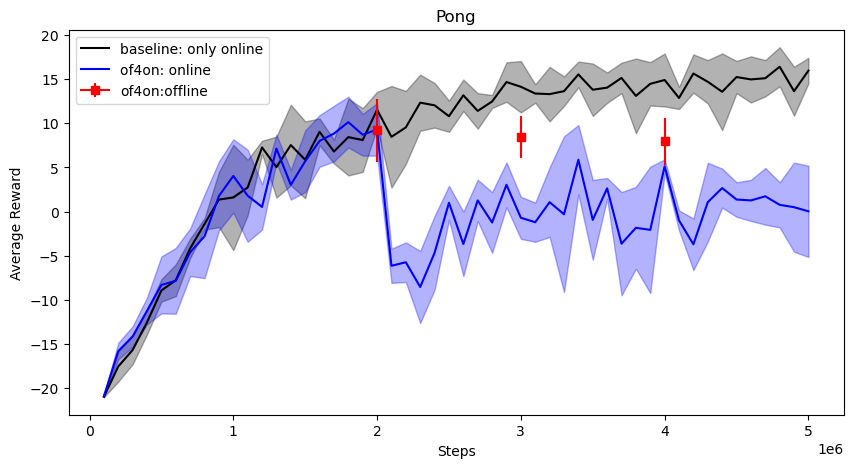

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
# baseline: online
baseline_color = "black"
steps = np.loadtxt(os.path.join(baseline_result_dirs[0], baseline_result_filename), delimiter=',')[:, 1]
mean = baseline_results.mean(axis=0)
std = baseline_results.std(axis=0)
ax.plot(steps, mean, label="baseline: only online", color=baseline_color)
ax.fill_between(steps, mean-std, mean+std, alpha=0.3, color=baseline_color)
ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title(game)
ax.legend()

# of4on
start_step = 0
online_color = 'blue'
offline_color = 'red'
steps = []
on_means = []
on_stds = []
for phase in range(1, 1+num_phases):
    of_phase_results = of4on_result[phase]["offline"]
    on_phase_results = np.stack(of4on_result[phase]["online"])
    on_steps = of4on_result[phase]["on_steps"] + start_step
    
    mean = on_phase_results.mean(axis=0)
    std = on_phase_results.std(axis=0)
    on_means += mean.tolist()
    on_stds += std.tolist()
    
    if len(of_phase_results) != 0:
        of_phase_results = np.array(of_phase_results)
        mean = of_phase_results.mean()
        std = of_phase_results.std()
        ax.errorbar(on_steps[-1], mean, yerr=std, xerr=0, marker='s', mfc=offline_color, mec=offline_color, color=offline_color, label="of4on:offline" if phase==4 else None)

    # update start_step
    start_step = on_steps[-1]
    
    steps += on_steps.tolist()

on_means = np.array(on_means)
on_stds = np.array(on_stds)
ax.plot(steps, on_means, label="of4on: online", color=online_color)
ax.fill_between(steps, on_means-on_stds, on_means+on_stds, alpha=0.3, color=online_color)

ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title(game)
ax.legend()

In [67]:
a = [1]
b= [1,2,3]
a+b

[1, 1, 2, 3]

In [3]:
import gym
import d3rlpy
from d3rlpy.dataset import MDPDataset

dataset_dir = os.path.join(project_root, "dataset")
env_name = "PongNoFrameskip-v0"
seed = 10
baseline_info = "Adam"
saved_dataset_path = os.path.join(dataset_dir, f"buffer_{env_name}_seed{seed}_onlineDoubleDQN_steps100000_baseline{baseline_info}.h5")
env = d3rlpy.envs.Atari(gym.make(env_name))
set_seed(10, env=env)
dataset = MDPDataset.load(saved_dataset_path)


In [16]:

from d3rlpy.algos import DiscreteCQL

cql = d3rlpy.algos.DiscreteCQL(
    learning_rate=5e-4,
    optim_factory=d3rlpy.models.optimizers.AdamFactory(eps=1e-2 / 32),
    batch_size=32,
    alpha=4.0,
    q_func_factory=d3rlpy.models.q_functions.QRQFunctionFactory(
        n_quantiles=200),
    scaler="pixel",
    n_frames=4,
    target_update_interval=1000,
    reward_scaler=d3rlpy.preprocessing.ClipRewardScaler(-1.0, 1.0),
    use_gpu=True,
    n_critics=2,
    )


In [17]:
dataset.observations.shape[0]

99999

In [18]:
from d3rlpy.metrics.scorer import evaluate_on_environment

eval_episode_num = 32
env_scorer = d3rlpy.metrics.evaluate_on_environment(env, n_trials=eval_episode_num, epsilon=0.001)
n_epochs = 5
n_steps_per_epoch = dataset.observations.shape[0]
n_steps = n_epochs * n_steps_per_epoch
experiment_name_offline_algo = f"test_cql_with_saved_ddqn_buffer"
show_progress = True
cql.fit(
    dataset.episodes,
    eval_episodes=[None], 
    n_steps=n_steps, # number of training steps
    n_steps_per_epoch=n_steps_per_epoch, # number of training steps per epoch
    scorers={
        'environment': env_scorer,
    },
    save_interval=n_epochs, # save the model only at the end of the offline learning
    experiment_name = experiment_name_offline_algo,
    show_progress = show_progress, # show progress bar. Set to False when deploying in the cluster to save the log file,
    n_epochs_per_eval = 1, # evaluate the model at the end of each epoch
)

2023-06-29 15:02:42 [debug    ] RandomIterator is selected.
2023-06-29 15:02:42 [info     ] Directory is created at d3rlpy_logs/test_cql_with_saved_ddqn_buffer_20230629150242
2023-06-29 15:02:42 [debug    ] Fitting scaler...              scaler=pixel
2023-06-29 15:02:42 [debug    ] Fitting reward scaler...       reward_scaler=clip
2023-06-29 15:02:42 [debug    ] Building models...
2023-06-29 15:03:03 [debug    ] Models have been built.
2023-06-29 15:03:03 [info     ] Parameters are saved to d3rlpy_logs/test_cql_with_saved_ddqn_buffer_20230629150242/params.json params={'action_scaler': None, 'alpha': 4.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0005, 'n_critics': 2, 'n_frames': 4, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0003125, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': 

Epoch 1/5:   0%|          | 0/99999 [00:00<?, ?it/s]

2023-06-29 15:31:28 [info     ] test_cql_with_saved_ddqn_buffer_20230629150242: epoch=1 step=99999 epoch=1 metrics={'time_sample_batch': 0.0003363466542723594, 'time_algorithm_update': 0.01534981568048789, 'loss': 155.25781757383174, 'cql_reg': 1.7525543438832636, 'time_step': 0.016422985501274537, 'environment': -21.0} step=99999


Epoch 2/5:   0%|          | 0/99999 [00:00<?, ?it/s]

2023-06-29 16:00:13 [info     ] test_cql_with_saved_ddqn_buffer_20230629150242: epoch=2 step=199998 epoch=2 metrics={'time_sample_batch': 0.00033924694277002586, 'time_algorithm_update': 0.015348377344037266, 'loss': 248.24222592384615, 'cql_reg': 1.7460779586083082, 'time_step': 0.016628874896899452, 'environment': -21.0} step=199998


Epoch 3/5:   0%|          | 0/99999 [00:00<?, ?it/s]

2023-06-29 16:27:06 [info     ] test_cql_with_saved_ddqn_buffer_20230629150242: epoch=3 step=299997 epoch=3 metrics={'time_sample_batch': 0.0003140227272672202, 'time_algorithm_update': 0.014395812257320725, 'loss': 207.00786306798005, 'cql_reg': 1.7465857374430773, 'time_step': 0.0155645803799194, 'environment': -21.0} step=299997


Epoch 4/5:   0%|          | 0/99999 [00:00<?, ?it/s]

2023-06-29 16:53:00 [info     ] test_cql_with_saved_ddqn_buffer_20230629150242: epoch=4 step=399996 epoch=4 metrics={'time_sample_batch': 0.0002995573507180079, 'time_algorithm_update': 0.013809878069941588, 'loss': 198.2754548689591, 'cql_reg': 1.7466932177587748, 'time_step': 0.014955480284287401, 'environment': -21.0} step=399996


Epoch 5/5:   0%|          | 0/99999 [00:00<?, ?it/s]

2023-06-29 17:18:59 [info     ] test_cql_with_saved_ddqn_buffer_20230629150242: epoch=5 step=499995 epoch=5 metrics={'time_sample_batch': 0.0003007939925705104, 'time_algorithm_update': 0.013872226193747075, 'loss': 197.8411450812201, 'cql_reg': 1.7467052056852126, 'time_step': 0.015018310478591236, 'environment': -21.0} step=499995
2023-06-29 17:18:59 [info     ] Model parameters are saved to d3rlpy_logs/test_cql_with_saved_ddqn_buffer_20230629150242/model_499995.pt


[(1,
  {'time_sample_batch': 0.0003363466542723594,
   'time_algorithm_update': 0.01534981568048789,
   'loss': 155.25781757383174,
   'cql_reg': 1.7525543438832636,
   'time_step': 0.016422985501274537,
   'environment': -21.0}),
 (2,
  {'time_sample_batch': 0.00033924694277002586,
   'time_algorithm_update': 0.015348377344037266,
   'loss': 248.24222592384615,
   'cql_reg': 1.7460779586083082,
   'time_step': 0.016628874896899452,
   'environment': -21.0}),
 (3,
  {'time_sample_batch': 0.0003140227272672202,
   'time_algorithm_update': 0.014395812257320725,
   'loss': 207.00786306798005,
   'cql_reg': 1.7465857374430773,
   'time_step': 0.0155645803799194,
   'environment': -21.0}),
 (4,
  {'time_sample_batch': 0.0002995573507180079,
   'time_algorithm_update': 0.013809878069941588,
   'loss': 198.2754548689591,
   'cql_reg': 1.7466932177587748,
   'time_step': 0.014955480284287401,
   'environment': -21.0}),
 (5,
  {'time_sample_batch': 0.0003007939925705104,
   'time_algorithm_upda